# <center>Asset Allocation Model V1.0<center>

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy.optimize import minimize

In [3]:
# Setting up parameters of plotting
mpl.rcParams['axes.unicode_minus'] = False
mpl.rc('figure', figsize=(12,5), titlesize='xx-large', dpi=110)
mpl.rc('font', size=12)
# Format the axis value as a percentage
func_format = lambda x, position: '%1.0f%%'%(100*x)
formatter = mpl.ticker.FuncFormatter(func_format)
# Load database
db = pd.read_excel('data/database_AA.xlsx', index_col=0).dropna()
# Spliting risk-free and risky assets
ret = db.iloc[12:].copy()
ret_rf = ret.pop('rf') 
# constant parameters of BL model (could be improved further with macro data and DL algorithms)
pred = pd.read_excel('data/database_AA.xlsx', index_col=0, sheet_name="pred").tail(1)*12.
rf=pred.pop('rf')

In [4]:
def ret2val(ret):
    "return to net value"
    init_date = ret.index.min() - pd.offsets.MonthEnd(1)
    val = pd.DataFrame(1, columns=ret.columns, index=[init_date]) 
    val = val.append((1+ret).cumprod())
    return val
def performance(ret, rf=ret_rf, if_format=True): 
    "measure:annualized return, volatility, sharpe ratio, max drawdown"
    start_str = ret.index.min().strftime('%Y/%m') 
    end_str = ret.index.max().strftime('%Y/%m') 
    val = ret2val(ret) 
    rf = rf.loc[ret.index] 
    ret_risk_adj = ret.sub(rf, axis=0) 
    n_years = len(ret) / 12
    res = pd.DataFrame()
    res['AR'] = val.iloc[-1] ** (1 / n_years) - 1
    res['Vol'] = ret.std() * (12**0.5)
    res['SR'] = ret_risk_adj.mean() * 12 / (ret_risk_adj.std() * 12**0.5) 
    res['MD'] = (val / val.expanding().max() - 1).min()
    res.index.name = '%s-%s'%(start_str, end_str)
    # string_formatting
    if if_format:
        col_fmt1 = ['AR', 'Vol', 'MD']
        res[col_fmt1] = res[col_fmt1].applymap(lambda x:'%.2f%%'%(x*100)) 
        col_fmt2 = ['SR']
        res[col_fmt2] = res[col_fmt2].applymap(lambda x:'%.3f'%(x))
    return res.T
def plot_value(ret):
    value = (1+ret).cumprod()
    value.plot(title='Trend of net value')
def get_feature_names(data):
    columns = data.columns.tolist()
    fea_names = [i for i in columns if i not in ["EW",'VW','RPM','SR','BL'] ] 
    return fea_names


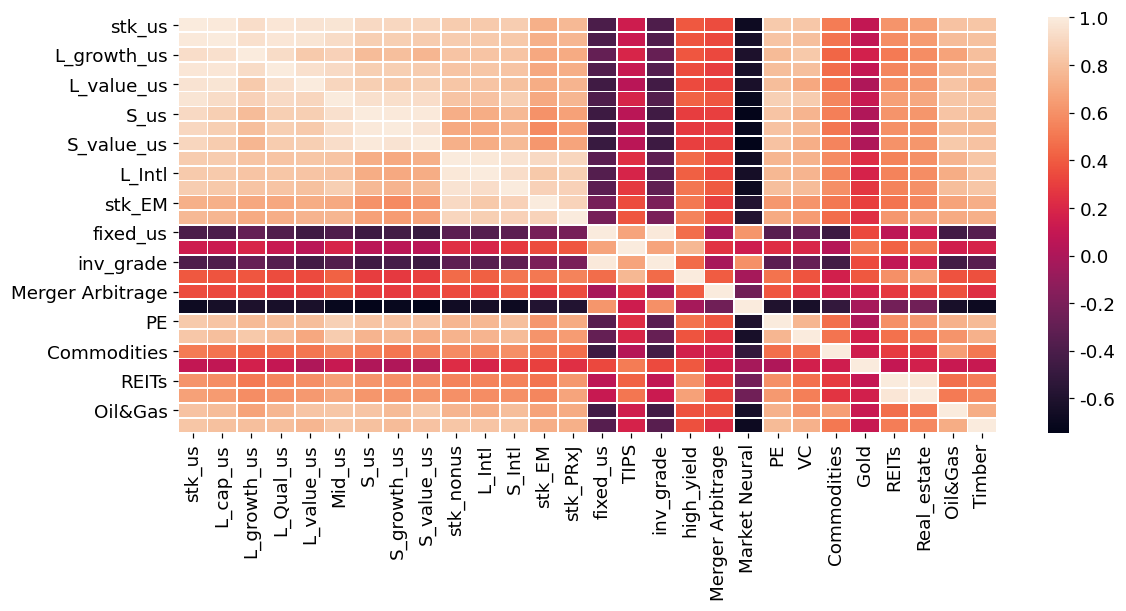

In [5]:
# Plotting correlation heatmap of risky assets
assets = get_feature_names(ret)
sns.heatmap(db[assets].corr(),linewidths=.5)

- As shown above, `equity assets` are highly **correlated**, `bonds`,`hedge funds`,`commodities`and `gold` are **low correlated**, and some of them are even **negatively correlated**.

## Back-testing framework

In [6]:
class TaaBasic: 
    """
    Parameters
    ----------
    ret_asset : DataFrame
    lookback(months) : int 
    signal_type : {"MA", "MOM"}
    weight_type : {None, "fixed", "ew", "vw"}
    top_n : int
    rebalance_periods(months) : int
    cost_rate : float
    """
    def __init__(self, ret_asset, lookback=12, signal_type='MA', weight_type='vw', risk_adjusted=True,
                 rf_name='rf',select_type='dual_mom', pred=pred, top_n=14, rebalance_periods=1, cost_rate=0):
        self.ret_asset = ret_asset
        risky = [ass for ass in ret_asset.columns if ass != rf_name] 
        self.ret_risky = ret_asset[risky]
        self.ret_rf = ret_asset[rf_name]
        self.ret_adj = self.ret_risky.sub(self.ret_rf,axis=0)
        self.lookback = lookback
        self.signal_type = signal_type
        self.weight_type = weight_type 
        self.risk_adjusted = risk_adjusted
        self.rf_name = rf_name
        self.select_type = select_type
        self.top_n = top_n
        self.rebalance_periods = rebalance_periods
        self.cost_rate = cost_rate
        self.Q = np.array(pred.iloc[0])
        
        self.run_model()
        
    def run_model(self): 
        self.mom = self.ret2mom() #1.calculate mom signal
        self.selected = self.select_asset() #2.select top assests
        self.w_target = self.weight() #3.calculate weights
        if self.risk_adjusted:
            self.risk_control() #4.apply risk strategy
        self.ret_pf = self.weight2return() #5.calculate return
    def ret2mom(self): 
        "calculate MOM/MA_MOM" 
        val = ret2val(self.ret_risky) 
        if self.signal_type == "MOM":
            val_start = val.shift(self.lookback) #MOM 
        elif self.signal_type == "MA":
            val_start = val.rolling(self.lookback+1).mean() #MA_MOM
        else:
            raise ValueError
        mom = val / val_start - 1
        mom = mom.shift(1).iloc[self.lookback+1:] 
        std = self.ret_risky.rolling(self.lookback).std(ddof=1)
        # volatilty adjustment
        mom_adj = mom / std
        mom_adj = mom_adj.shift(1).iloc[self.lookback+1:]
        return mom_adj
    
    def select_asset(self): 
        if self.select_type == "basic":
            columns = self.mom.columns
            index = self.mom.index
            selected = pd.DataFrame(1, columns=columns, index=index)
        if self.select_type == "dual_mom":
            mom_rank = self.mom.rank(1, ascending=False)
            selected = (mom_rank <= self.top_n).astype(int)
        return selected

    def weight(self): 
        if self.weight_type == "fixed":
            w_fixed = [0.25/14] * 14 + [0.0625] * 4 + [0.0625] * 4 + [0.25/6] * 6
            w_target = self.selected.mul(w_fixed, axis=1)
        elif self.weight_type == "ew":
            w_target = self.selected.mul(1 / self.selected.sum(1), axis=0)
        elif self.weight_type == "vw":
            lb = self.lookback
            std = self.ret_risky.rolling(lb).std(ddof=1).shift(1).iloc[lb:] 
            w_vol = 1 / std * self.selected
            # Normalize
            w_target = w_vol.div(w_vol.sum(1), axis=0)
        elif self.weight_type == "rpm":
            def calculate_portfolio_var(w,V):
                w = np.matrix(w)
                return (w*V*w.T)[0,0]
            def calculate_risk_contribution(w,V):
                w = np.matrix(w)
                sigma = np.sqrt(calculate_portfolio_var(w,V))
                MRC = V*w.T
                RC = np.multiply(MRC,w.T)/sigma
                return RC 
            def risk_budget_objective(x):
                sig_p = np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
                risk_target = np.asmatrix(np.multiply(sig_p,w0))
                asset_RC = calculate_risk_contribution(x,V)
                J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
                return J
            lb = self.lookback
            test = self.ret_risky
            columns = test.columns
            index = test.index[12:]
            w_target = pd.DataFrame(columns=columns, index=index)
            N = len(columns)
            mycons = ({'type':'eq','fun':lambda x:np.sum(x)-1})
            mybnds = tuple((0,0.3) for x in range(N)) # if shortsell is NOT constrained, use tuple((-1,1) for x in range(N))
            w0 = np.array([1./N]*N) # default equal weight, 1*N array
            for i in range(len(test)-12):
                V=(test.iloc[12-lb+i:12+i].cov()*12.).to_numpy()
                res=minimize(risk_budget_objective, w0, method='SLSQP',constraints=mycons,bounds=mybnds)
                w_target.iloc[i]=res.x.round(10).tolist()
        elif self.weight_type == "max_sr":
            def max_sr(weights):
                weights = np.array(weights)
                port_abreturns = np.sum(ab_r*weights)
                port_abvariance = np.sqrt((weights.T).dot(port_cov).dot(weights))
                return -1*port_abreturns/port_abvariance
            test = self.ret_adj
            lb = self.lookback
            columns = test.columns
            index = test.index[12:]
            w_target = pd.DataFrame(columns=columns, index=index)
            k = len(columns)
            bnds = tuple((0,0.3) for x in range(k))   
            cons = ({'type':'eq','fun':lambda x:np.sum(x)-1})
            for i in range(len(test)-12):
                tmp = test.iloc[:12+i]
                ab_r = tmp.mean()*12.
                port_cov = tmp.cov()*12.
                res= minimize(max_sr,[1./k]*k, method='SLSQP',constraints=cons,bounds=bnds)
                w_target.iloc[i]=res.x.round(10).tolist()
        elif self.weight_type == "bl":
            def max_sr_bl(weights):
                weights = np.array(weights)
                port_abreturns = np.sum(adjustedReturn*weights)
                port_abvariance = np.sqrt((weights.T).dot(Sigma_p).dot(weights))
                return -1*port_abreturns/port_abvariance
            test = self.ret_adj
            lb = self.lookback
            columns = test.columns
            index = test.index[12:]
            w_target = pd.DataFrame(columns=columns, index=index)
            n_ass = len(columns)
            P = np.eye(n_ass)
            Q = self.Q
            bnds = tuple((0,0.3) for x in range(n_ass))   
            cons = ({'type':'eq','fun':lambda x:np.sum(x)-1})
            for i in range(len(test)-12):
                tmp = test.iloc[:12+i]
                tau = 1./len(tmp)
                expected_return = tmp.mean()*12.
                covmat = tmp.cov()*12.
                Omega = tau*(P.dot(covmat).dot(P.T))
                Omega = np.diag(np.diag(Omega,k=0))
                adjustedReturn = expected_return + tau*covmat.dot(P.transpose()).dot(np.linalg.inv(Omega+tau*(P.dot(covmat).dot(P.transpose())))).dot(Q - P.dot(expected_return))
                right = (tau)*covmat.dot(P.transpose()).dot(np.linalg.inv(Omega+P.dot(covmat).dot(P.transpose()))).dot(P.dot(tau*covmat))
                right = right.transpose()
                right = right.set_index(expected_return.index)
                M = tau*covmat - right
                Sigma_p = covmat + M
                res= minimize(max_sr_bl,[1./n_ass]*n_ass, method='SLSQP',constraints=cons,bounds=bnds)
                w_target.iloc[i]=res.x.round(10).tolist()
        w_target = w_target.iloc[::self.rebalance_periods] 
        w_target = w_target.clip(lower=0, upper=1)
        return w_target
    
    def risk_control(self, threshold=0): 
        signal_value = self.mom.reindex(self.w_target.index)
        # trigger when signal < threshold,label asset weight as 0
        self.signal_rc = (signal_value > threshold).astype(int) 
        self.w_target = self.signal_rc * self.w_target
        self.w_target[self.rf_name] = 1 - self.w_target.sum(1)
        self.w_target = self.w_target.clip(lower=0, upper=1)
    def cal_w_sod(self): 
        "calculate initiating weight"
        def w_sod_period(ret_period):
            "calculate initiating weight at each reblance period" 
            date_reb = ret_period.index.min() 
            w_init = self.w_target.loc[date_reb] 
            if ret_period.shape[0]>1:
                val = (1+ret_period).cumprod()
                val_eod = val.mul(w_init, axis=1)
                w_eod_period = val_eod.div(val_eod.sum(1), axis=0) 
                w_sod_period = w_eod_period.shift(1) 
                w_sod_period.iloc[0] = w_init
                return w_sod_period
            else:
                return w_init.to_frame().T
        date_idx = self.w_target.index
        ret_asset = self.ret_asset.loc[date_idx.min():]
        dates_reb = pd.Series(date_idx, index=date_idx)
        dates_map = dates_reb.reindex(ret_asset.index).fillna(method='ffill')
        w_sod = ret_asset.groupby(dates_map.values, group_keys=False).apply(w_sod_period) 
        return w_sod

    def weight2return(self):
        self.w_sod = self.cal_w_sod() 
        ret_asset = self.ret_asset.loc[self.w_sod.index.min():]
        val_eod = self.w_sod * (1 + ret_asset) 
        self.w_eod = val_eod.div(val_eod.sum(1), axis=0) 
        ret_pf = val_eod.sum(1) - 1 
        if self.cost_rate:
            w_sod = self.w_sod.shift(-1).fillna(0)
            turnover = (w_sod - self.w_eod).abs().sum(1) 
            cost = turnover * self.cost_rate
            cost.iloc[0] = 1 - (1-cost.iloc[0]) * (1-self.cost_rate)
            ret_pf = (1 + ret_pf) * (1 - cost) - 1
        return ret_pf

In [7]:
# Sensitity analysis on lookback periods
# DualMom_VolAdj_VW
list_lookback = [3, 6, 9, 12]
def report_generate(signal_type, list_lookback):
    retPort_generate_mom = lambda lookback: TaaBasic(db, signal_type=signal_type,lookback=lookback).ret_pf.rename('%s%d'%(signal_type, lookback))
    lres = list(map(retPort_generate_mom, list_lookback))
    ret = pd.concat(lres, axis=1).dropna()
    return ret

ret_mom = report_generate('MOM', list_lookback) 
ret_ma = report_generate('MA', list_lookback) 
ret_lookback = pd.concat([ret_mom,ret_ma],axis=1)

performance(ret_lookback)

2012/10-2020/05,MOM3,MOM6,MOM9,MOM12,MA3,MA6,MA9,MA12
AR,3.72%,5.99%,6.24%,5.51%,4.30%,5.50%,5.58%,6.04%
Vol,7.45%,7.69%,7.82%,8.33%,7.21%,7.47%,7.37%,7.46%
SR,0.416,0.687,0.707,0.586,0.505,0.642,0.660,0.712
MD,-13.72%,-10.60%,-9.40%,-14.11%,-11.20%,-11.98%,-10.96%,-10.68%


In [8]:
# RPM
lb_rpm=lambda n: TaaBasic(db, weight_type='rpm',risk_adjusted=False,select_type='basic',lookback=n).ret_pf.rename('RPM%d'%n)
ret_lb_rpm=pd.concat([lb_rpm(x) for x in list_lookback], axis=1)
performance(ret_lb_rpm)


2012/10-2020/05,RPM3,RPM6,RPM9,RPM12
AR,4.56%,5.00%,4.19%,4.23%
Vol,7.73%,7.56%,8.47%,8.58%
SR,0.508,0.573,0.429,0.429
MD,-12.16%,-10.76%,-14.57%,-15.21%


As for max_SR and BL model, entire history was selected.

In [9]:
# Sensitity analysis on rebalance periods
# DualMom_VolAdj_VW
cost_rate=0.003
func_rebalance = lambda n: TaaBasic(db, cost_rate=cost_rate, rebalance_periods=n).ret_pf.rename('%dM'%n)
months = [1, 2, 3, 6, 12]
ret_reb = pd.concat([func_rebalance(x) for x in months], axis=1)
performance(ret_reb)

2012/10-2020/05,1M,2M,3M,6M,12M
AR,4.53%,3.29%,4.64%,4.81%,3.12%
Vol,7.52%,8.32%,7.76%,7.64%,7.63%
SR,0.516,0.331,0.516,0.545,0.333
MD,-11.92%,-16.72%,-13.48%,-13.37%,-13.90%


In [10]:
# RPM
rpm_reb = lambda n: TaaBasic(db,weight_type='rpm',risk_adjusted=False,select_type='basic',lookback=6,cost_rate=cost_rate, rebalance_periods=n).ret_pf.rename('%dM'%n)
ret_rpm_reb = pd.concat([rpm_reb(x) for x in months], axis=1)
performance(ret_rpm_reb)

2012/10-2020/05,1M,2M,3M,6M,12M
AR,4.24%,4.36%,3.83%,4.44%,3.86%
Vol,7.62%,8.17%,8.11%,8.56%,8.58%
SR,0.475,0.461,0.401,0.454,0.388
MD,-11.21%,-13.86%,-13.66%,-13.16%,-12.91%


In [11]:
# max_SR
rpm_sr = lambda n: TaaBasic(db,weight_type='max_sr',risk_adjusted=False,select_type='basic',cost_rate=cost_rate, rebalance_periods=n).ret_pf.rename('%dM'%n)
ret_rpm_sr = pd.concat([rpm_sr(x) for x in months], axis=1)
performance(ret_rpm_sr)

2012/10-2020/05,1M,2M,3M,6M,12M
AR,4.35%,4.44%,4.39%,4.48%,4.77%
Vol,6.14%,6.04%,6.04%,5.99%,5.95%
SR,0.592,0.615,0.607,0.625,0.675
MD,-8.48%,-8.34%,-8.06%,-8.17%,-8.03%


In [12]:
# BL
rpm_bl = lambda n: TaaBasic(db,weight_type='bl',risk_adjusted=False,select_type='basic',cost_rate=cost_rate, rebalance_periods=n).ret_pf.rename('%dM'%n)
ret_rpm_bl = pd.concat([rpm_bl(x) for x in months], axis=1)
performance(ret_rpm_bl)

2012/10-2020/05,1M,2M,3M,6M,12M
AR,5.86%,6.13%,5.99%,5.82%,5.87%
Vol,5.04%,5.04%,5.04%,5.00%,4.99%
SR,1.001,1.050,1.025,0.999,1.011
MD,-5.58%,-5.82%,-5.43%,-5.65%,-5.64%


In [13]:
# SAA
test_m=pd.DataFrame(index=ret.index)
test_m['EW']=TaaBasic(db,weight_type='ew', risk_adjusted=False,select_type='basic',cost_rate=cost_rate).ret_pf
test_m['RPM']=TaaBasic(db,weight_type='rpm', risk_adjusted=False,select_type='basic',lookback=6,cost_rate=cost_rate).ret_pf
test_m['SR']=TaaBasic(db,weight_type='max_sr', risk_adjusted=False,select_type='basic',rebalance_periods=12,cost_rate=cost_rate).ret_pf
test_m['BL']=TaaBasic(db,weight_type='bl', risk_adjusted=False,select_type='basic',rebalance_periods=3,cost_rate=cost_rate).ret_pf
port_0=test_m[['EW','RPM','SR','BL']]
performance(port_0)

2012/10-2020/05,EW,RPM,SR,BL
AR,4.10%,4.24%,4.77%,5.99%
Vol,10.46%,7.62%,5.95%,5.04%
SR,0.361,0.475,0.675,1.025
MD,-20.19%,-11.21%,-8.03%,-5.43%


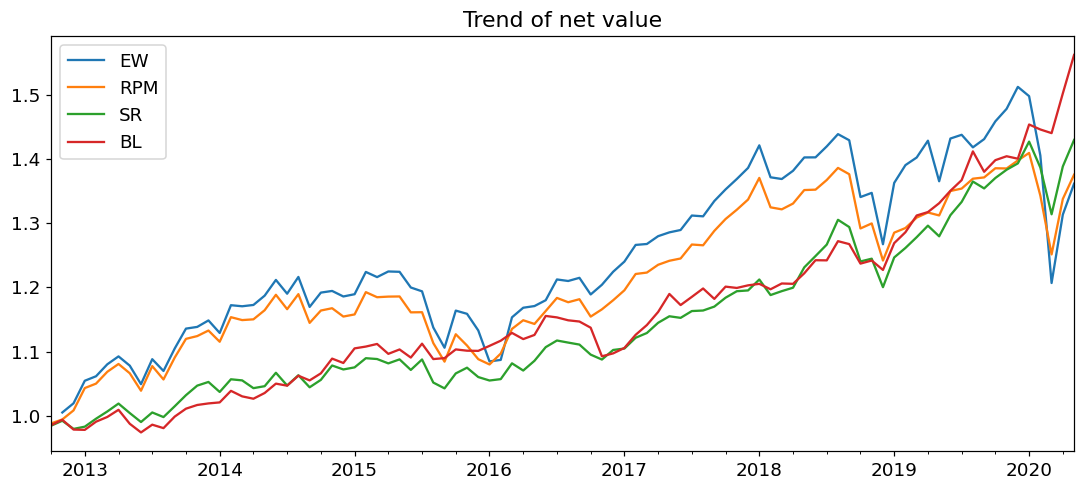

In [14]:
plot_value(port_0)

In [15]:
# TAA
ret['EW'] = TaaBasic(db, weight_type='ew',cost_rate=cost_rate).ret_pf
ret['VW'] = TaaBasic(db, rebalance_periods=6, cost_rate=cost_rate).ret_pf
ret['RPM'] = TaaBasic(db,weight_type='rpm',lookback=6,cost_rate=cost_rate).ret_pf
ret['SR']=TaaBasic(db,weight_type='max_sr',rebalance_periods=12,cost_rate=cost_rate).ret_pf
ret['BL']=TaaBasic(db,weight_type='bl',rebalance_periods=3,cost_rate=cost_rate).ret_pf
port_1=ret[['EW','VW','RPM','SR','BL']]
performance(port_1)

2012/10-2020/05,EW,VW,RPM,SR,BL
AR,4.21%,4.81%,2.83%,3.86%,4.78%
Vol,8.93%,7.64%,5.40%,5.06%,5.02%
SR,0.418,0.545,0.390,0.614,0.795
MD,-15.22%,-13.37%,-9.68%,-8.05%,-7.77%


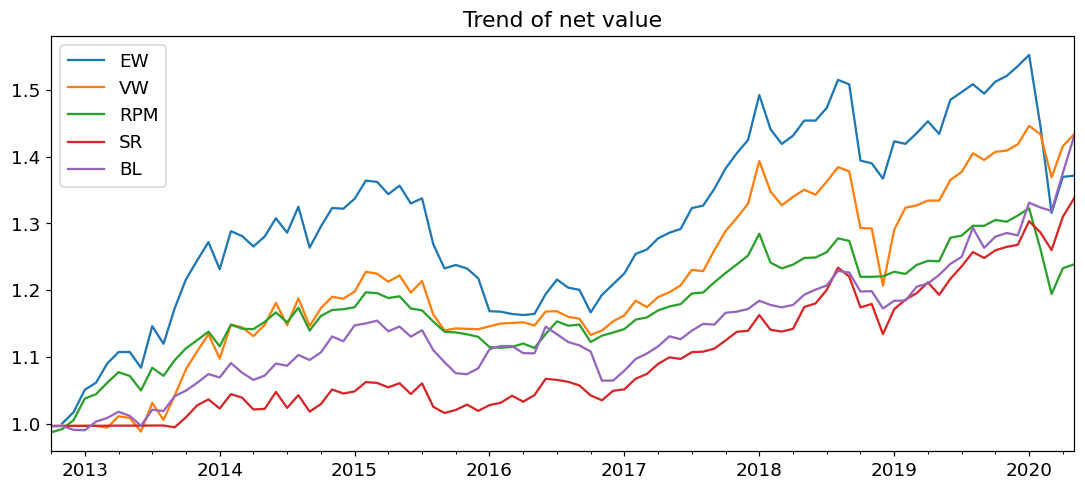

In [16]:
plot_value(port_1)

## Back-testing assets & Investment vehicles

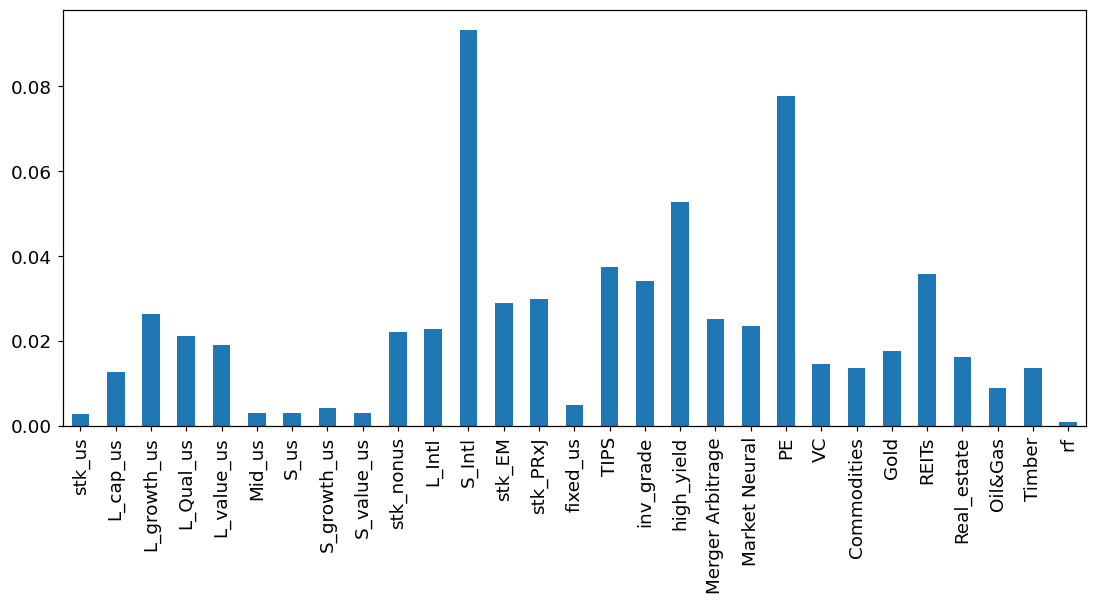

In [17]:
etf = pd.read_excel('data/database_AA.xlsx', index_col=0,sheet_name="etf").iloc[:-2]
idx = db.loc[etf.index, etf.columns]
# annualized tracking error
err = etf - idx
tracking_error = err.std() * (12 ** .5)
tracking_error.plot(kind='bar')

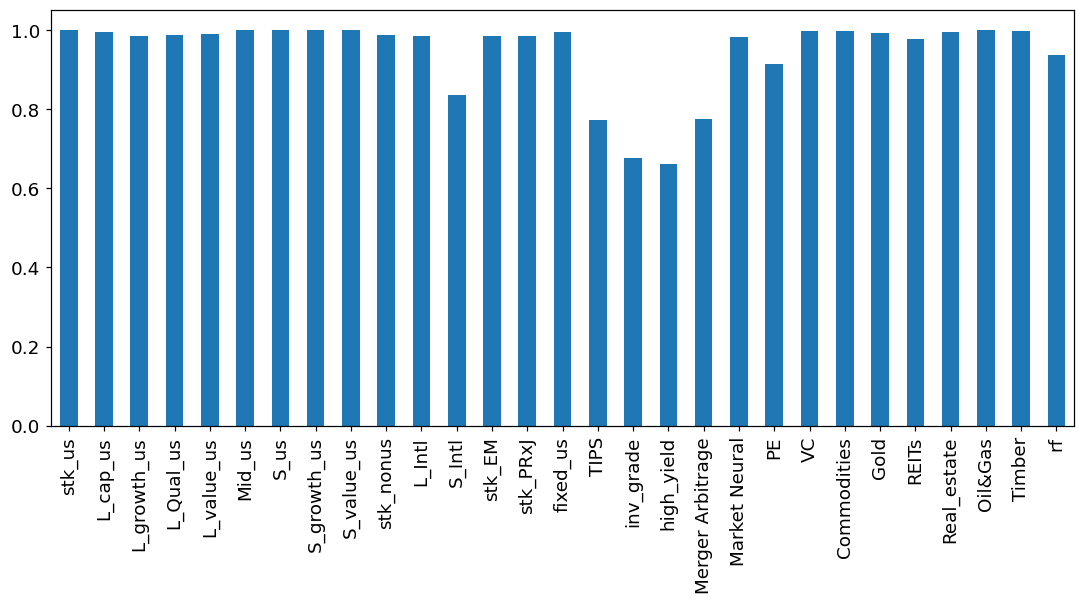

In [18]:
# corelation coefficient between index and corresponding ETF
idx.corrwith(etf).plot(kind='bar')

mean gap on return:1.38%


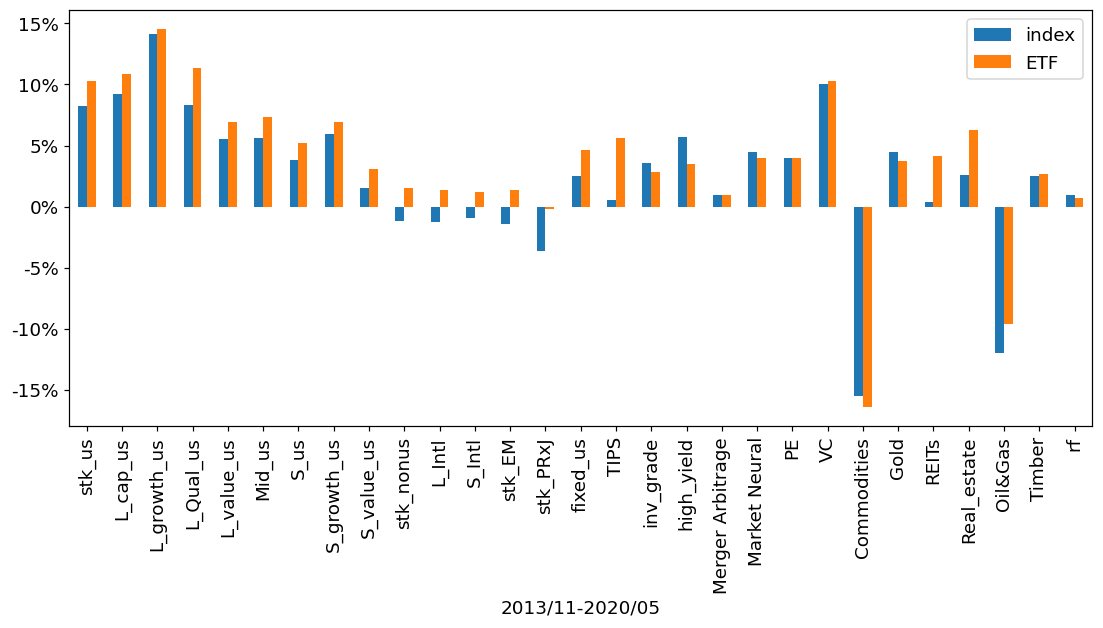

In [19]:
# comparasion between index and corresponding ETF
pf_idx = performance(idx, if_format=False).loc['AR']
pf_etf = performance(etf, if_format=False).loc['AR']
pf_compare = pd.concat([pf_idx, pf_etf], axis=1, keys=['index', 'ETF'])
ax = pf_compare.plot(kind='bar')
ax.yaxis.set_major_formatter(formatter)
print('mean gap on return:%.2f%%'%((pf_compare['ETF'] - pf_compare['index']).mean()*100))

In [22]:
s1=TaaBasic(db,weight_type='ew', risk_adjusted=False,select_type='basic',cost_rate=cost_rate).cal_w_sod().tail(1).T
s2=TaaBasic(db,weight_type='rpm', risk_adjusted=False,select_type='basic',lookback=6,cost_rate=cost_rate).cal_w_sod().tail(1).T
s3=TaaBasic(db,weight_type='max_sr', risk_adjusted=False,select_type='basic',rebalance_periods=12,cost_rate=cost_rate).cal_w_sod().tail(1).T
s4=TaaBasic(db,weight_type='bl', risk_adjusted=False,select_type='basic',rebalance_periods=3,cost_rate=cost_rate).cal_w_sod().tail(1).T
ss=pd.concat([s1,s2,s3,s4],axis=1)

In [24]:
ss.to_csv('saa_weights.csv')

In [25]:
t1 = TaaBasic(db, weight_type='ew',cost_rate=cost_rate).cal_w_sod().tail(1).T
t2 = TaaBasic(db, rebalance_periods=6, cost_rate=cost_rate).cal_w_sod().tail(1).T
t3 = TaaBasic(db,weight_type='rpm',lookback=6,cost_rate=cost_rate).cal_w_sod().tail(1).T
t4 = TaaBasic(db,weight_type='max_sr',rebalance_periods=12,cost_rate=cost_rate).cal_w_sod().tail(1).T
t5 = TaaBasic(db,weight_type='bl',rebalance_periods=3,cost_rate=cost_rate).cal_w_sod().tail(1).T
tt = pd.concat([t1,t2,t3,t4,t5],axis=1)
tt.to_csv('taa_weights.csv')